<a href="https://colab.research.google.com/github/sourabhkmr/Personal-Projects/blob/main/EMD_syntax_corrected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import pywt

f = [8,24,30]
n_modes = 3
total_time = 5
deltaT = 0.001
nu = 1
MaxErr = 0.001
maxIMF = 10
MaxSiftIter = 100

def create_signal(n_modes,f,total_time,deltaT):
    signal = 0
    time = np.arange(0, total_time + deltaT, deltaT)

    for i in range(n_modes):
        signal = signal + np.sin(2*np.pi*f[i]*time)

    return time, signal

def signal_extension(signal,nu):

    L = len(signal)
    sig_mean = np.mean(signal)
    sig_without_mean = signal - sig_mean
    sig_ext = pywt.pad(sig_without_mean,(nu*L,nu*L),'antireflect')

    chi = []
    L_s  = len(sig_ext)

    for i in range(L_s):
        if i < nu*L-1:
            chi.append(1/2*(np.cos(i*np.pi/nu/L-np.pi)+1))
        elif i < nu*L+L-1:
            chi.append(1)
        else:
            chi.append(1/2*(np.cos((L_s-i-1)*np.pi/nu/L-np.pi)+1))

    chi_array = np.asarray(chi)
    sig_mod = chi_array * sig_ext + sig_mean

    return sig_mod

def find_extrema(s):

    extrema_location = []
    d = np.diff(s)
    for i in range(len(s)-2):
        if np.sign(d[i]) != np.sign(d[i+1]):
            extrema_location.append(i+1)

    extrema_loc = np.asarray(extrema_location)
    return extrema_loc

def findMaxMin(s,extrema_loc):

    max_location, min_location = [], []
    max_value, min_value = [], []

    if s[extrema_loc[0]] > s[extrema_loc[1]]:
        count = 0
        while count < len(extrema_loc)-1:
            max_location.append(extrema_loc[count])
            min_location.append(extrema_loc[count+1])
            count += 2
    else:
        count = 0
        while count < len(extrema_loc)-1:
            max_location.append(extrema_loc[count+1])
            min_location.append(extrema_loc[count])
            count += 2

    max_loc = np.asarray(max_location)
    min_loc = np.asarray(min_location)

    for i in range(len(max_loc)):
        max_value.append(s[max_loc[i]])

    for i in range(len(min_loc)):
        min_value.append(s[min_loc[i]])

    max_val = np.asarray(max_value)
    min_val = np.asarray(min_value)

    return max_loc, max_val, min_loc, min_val

def create_extrema_envelop(s, max_loc, max_val, min_loc, min_val):

    cs_maxima = CubicSpline(max_loc, max_val)
    cs_minima = CubicSpline(min_loc, min_val)

    x = np.arange(0, len(s), 1)

    max_env = cs_maxima(x)
    min_env = cs_minima(x)

    return max_env, min_env

def mean_env(max_env, min_env):
    env_mean = np.zeros(len(max_env))
    for i in range(len(max_env)):
        env_mean[i] = 0.5 * (max_env[i] + min_env[i])

    return env_mean

def test1(imf_iter):

    cross_count = 0
    extrema = find_extrema(imf_iter)
    for i in range(len(imf_iter)-1):
        if imf_iter[i] * imf_iter[i+1] < 0:
            cross_count += 1
    if np.abs(len(extrema)-cross_count) < 2:
        return False
    else:
        return True

def test2(imf_iter):

    extrema_loc = find_extrema(imf_iter)
    extrema = findMaxMin(imf_iter,extrema_loc)
    max_loc, max_val = extrema[0], extrema[1]
    min_loc, min_val = extrema[2], extrema[3]
    max_env, min_env = create_extrema_envelop(imf_iter, max_loc, max_val,
                                            min_loc, min_val)
    env_mean = mean_env(max_env, min_env)

    if np.abs(np.max(env_mean)*np.min(env_mean)) < MaxErr:
        return False
    else:
        return True

def test3(nSift,MaxSiftIter):

    if nSift > MaxSiftIter:
        return False
    else:
        return True

def emd(sig_mod,maxIMF,MaxErr,MaxSiftIter):

    n_IMF = 0
    IMF_list = []
    s = sig_mod

    while n_IMF < maxIMF:
        nSift = 0
        t1, t2, t3 = True, True, True
        while (t1 or t2) and t3:
            extrema_loc = find_extrema(s)

            if len(extrema_loc) < 2:
                break

            extrema = findMaxMin(s,extrema_loc)
            max_loc, max_val = extrema[0], extrema[1]
            min_loc, min_val = extrema[2], extrema[3]
            max_env, min_env = create_extrema_envelop(s, max_loc, max_val,
                                                    min_loc, min_val)
            env_mean = mean_env(max_env, min_env)

            imf_iter = s - env_mean
            s = imf_iter
            nSift += 1
            t1 = test1(imf_iter)
            t2 = test2(imf_iter)
            t3 = test3(nSift,MaxSiftIter)

            print(n_IMF,nSift)

        IMF_list.append(imf_iter)
        n_IMF += 1
        sum_IMF = np.zeros(len(sig_mod))
        for i in range(n_IMF):
            sum_IMF += IMF_list[i]
        s = sig_mod - sum_IMF

    IMF = np.asarray(IMF_list)

    return IMF

time, signal = create_signal(n_modes,f,total_time,deltaT)
sig_mod = signal_extension(signal,nu)
IMF = emd(sig_mod,maxIMF,MaxErr,MaxSiftIter)


0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
1 1
1 2
2 1
3 1
3 2
4 1
6 1
8 1


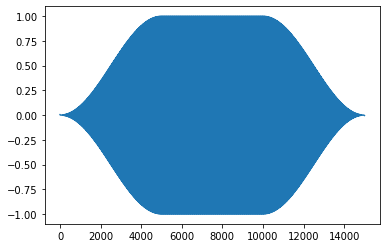

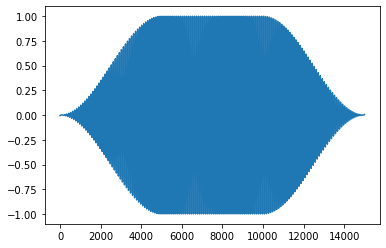

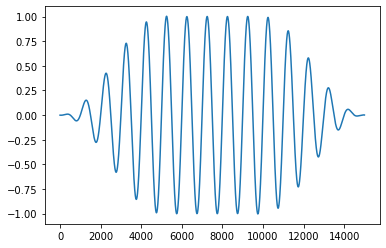

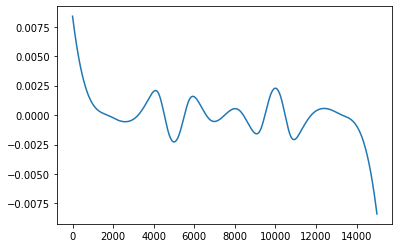

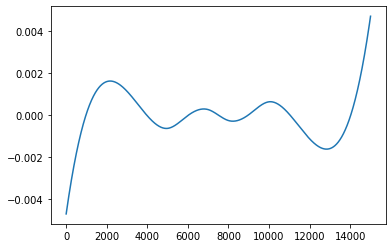

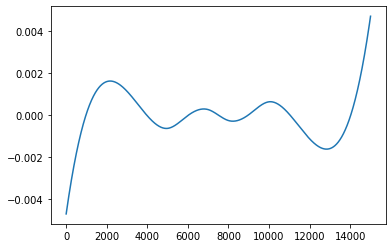

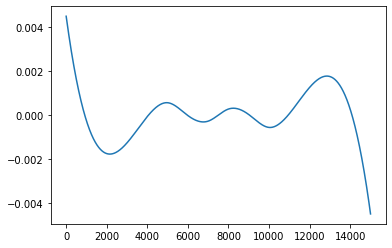

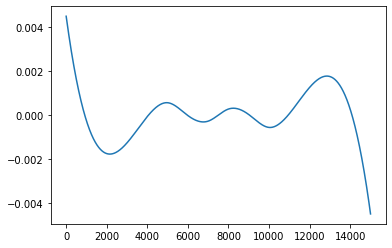

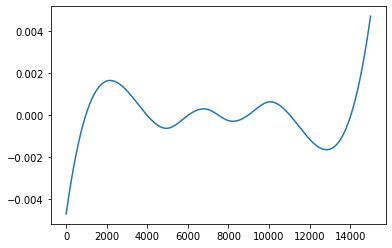

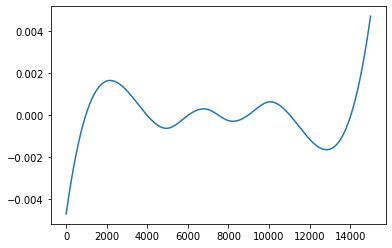

In [ ]:
for x in range(len(IMF)):
  plt.plot(IMF[x,:])
  #plt.xlim(7000,9000)
  plt.show()
  plt.close()